In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# import warnings.simplefilter("ignor")

from google.colab import drive
drive.mount('/content/drive')

sns.set(style="darkgrid")

In [ ]:
dir_data = './drive/MyDrive/SF/SF Webinars/Регрессия и Классификация/'
data = pd.read_csv(dir_data+'kc_house_data.csv')


FileNotFoundError: ignored

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [ ]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
data.shape

(21613, 21)

In [ ]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Первое, что стоит заметить — у нас в данных есть уникальное для каждого объекта поле id. Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

Вопрос 1: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

Вопрос 2: Почему стоит дополнительно отделять валидационную выборку?

Вопрос 3: Обратите внимание на фиксацию random_state при сплите данных. Почему это важно?


Заметим, что не все признаки имеют смысл, удалим их.


In [ ]:
data = data.drop(columns=['id','zipcode','date','lat','long'])

In [ ]:
data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

y = data['price']
X = data.drop(columns='price')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


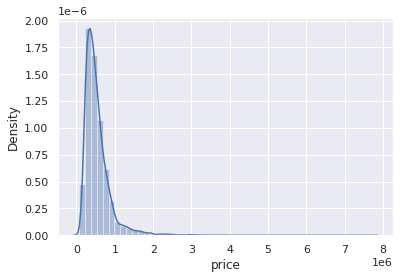

In [ ]:
sns.distplot(y_train)

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. 

Вопрос: Что означает, что коэффициент корреляции Пирсона между двумя случайными величинами равен -1?

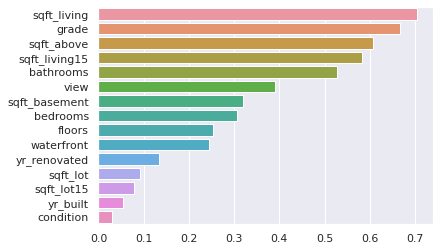

In [ ]:
correlations = X_train.corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет (такие графики называются scatter-plot).


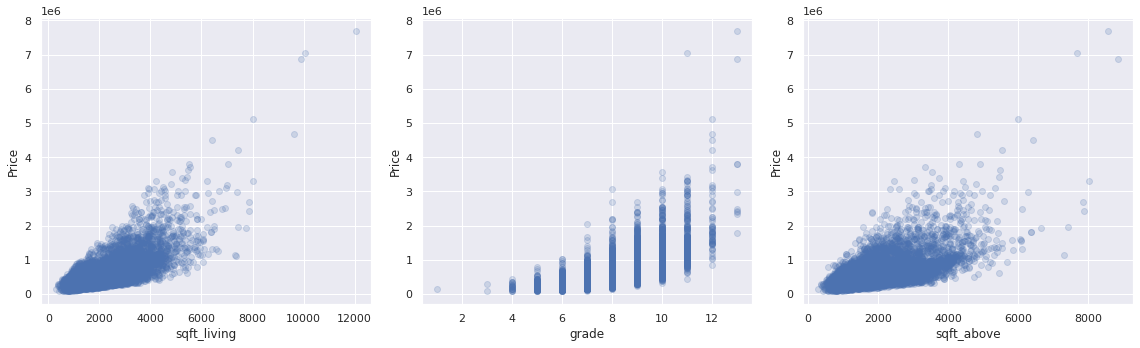

In [ ]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(['sqft_living', 'grade', 'sqft_above' ]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Price")
plt.tight_layout()


Видим, что между этими признаками и целевой переменной действительно наблюдается линейная зависимость.

##Построим первую модель

Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. В sklearn есть несколько классов, реализующих линейную регрессию:

LinearRegression — "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$

Ridge — линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией

Lasso — линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

У моделей из sklearn есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 223915.7123
Train RMSE = 212653.6830



Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. 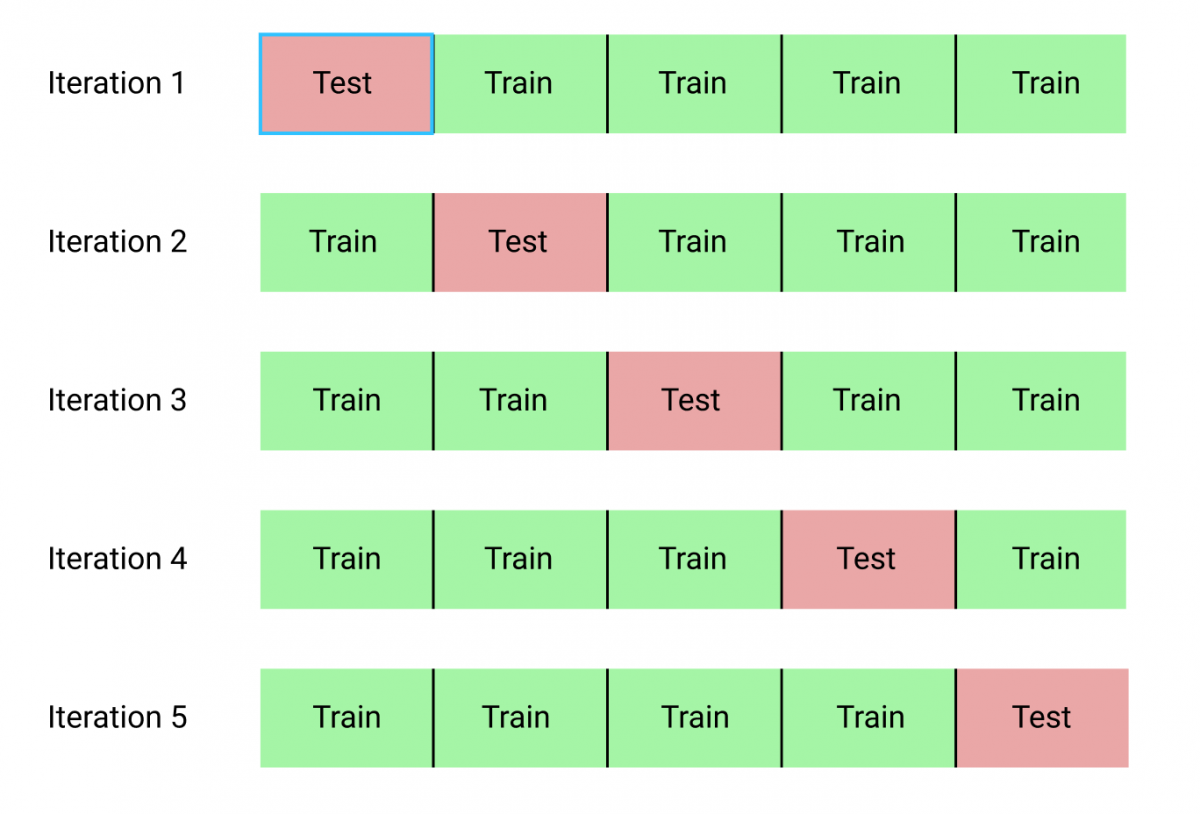



При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -263345.1418
	-198929.8605
	-243281.7860
	-191615.4231
	-203165.9930
	-217316.9751
	-206195.6257
	-203274.6219
	-198123.0873
	-199493.4587
Mean CV RMSE = 212474.1973


Обратите внимание на то, что результаты cv_scores получились отрицательными. Это соглашение в sklearn (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются neg_*, например, neg_root_mean_squared_error.



Если бы RMSE не входил в стандартные метрики sklearn, можно было бы его определить через функцию sklearn.metrics.make_scorer.

In [ ]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -263345.1418
	-198929.8605
	-243281.7860
	-191615.4231
	-203165.9930
	-217316.9751
	-206195.6257
	-203274.6219
	-198123.0873
	-199493.4587
Mean CV RMSE = 212474.1973


Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.


In [ ]:
constant = y_train.mean()
print("Test RMSE with constant = %.4f" % mean_squared_error(y_test, constant * np.ones(y_test.shape),squared=False))
print("Train RMSE with constant = %.4f" % mean_squared_error(y_train, constant * np.ones(y_train.shape),squared=False))

Test RMSE with constant = 380043.5678
Train RMSE with constant = 361449.7336


Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес — тем более сильным является признак.

#Вопрос: Почему это не совсем правда?

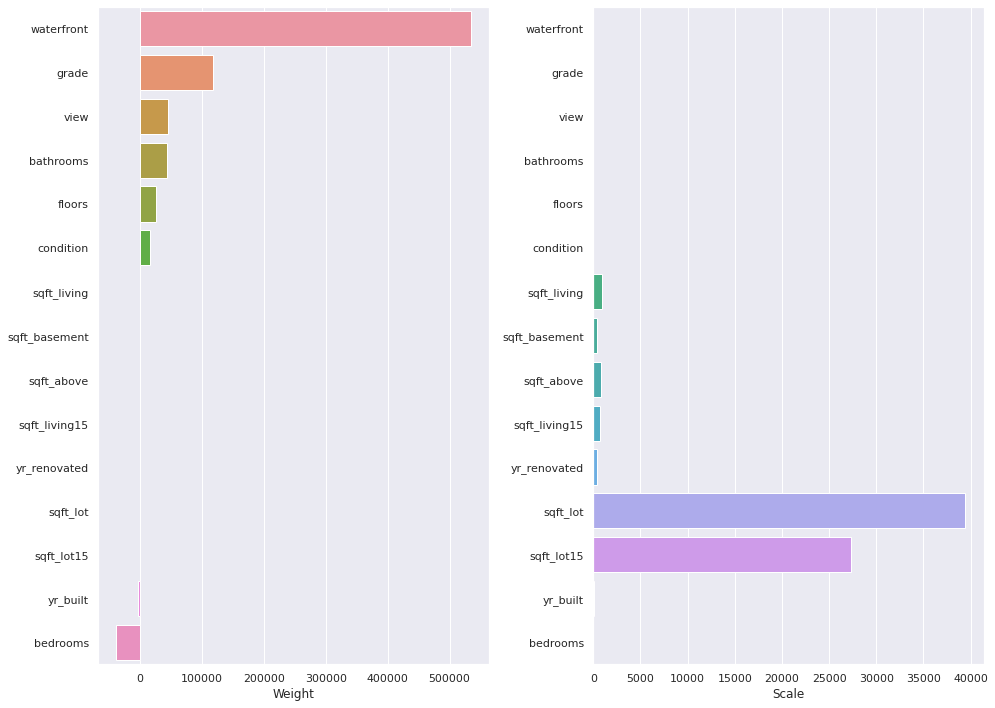

In [ ]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

    
show_weights(X.columns, model.coef_, X_train.std())

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

Для этого воспользуемся трансформером StandardScaler. Трансформеры в sklearn имеют методы fit и transform (а еще fit_transform). Метод fit принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как StandardScaler: среднее и стандартное отклонение каждого из признаков). transform применяет преобразование к переданной выборке.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 223893.9846
Train RMSE = 212653.1889


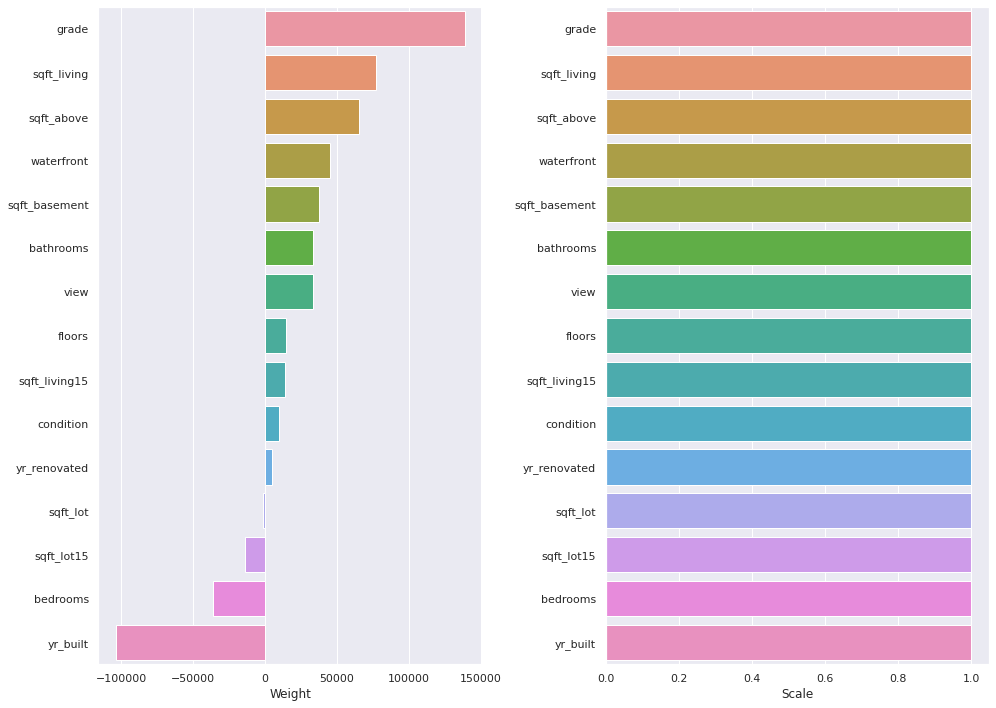

In [ ]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=X.columns)
show_weights(X.columns, model.coef_, scales)


Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это alpha — коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем alpha по логарифмической сетке, чтобы узнать оптимальный порядок величины).

Best alpha = 155.5676


Text(0, 0.5, 'CV score')

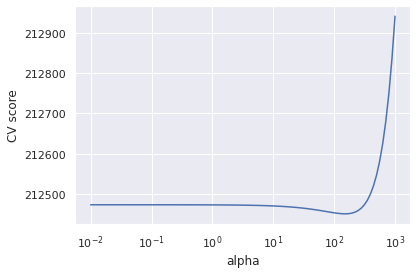

In [ ]:

from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 100)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [ ]:
alphas

array([1.00000000e-02, 2.06913808e-02, 4.28133240e-02, 8.85866790e-02,
       1.83298071e-01, 3.79269019e-01, 7.84759970e-01, 1.62377674e+00,
       3.35981829e+00, 6.95192796e+00, 1.43844989e+01, 2.97635144e+01,
       6.15848211e+01, 1.27427499e+02, 2.63665090e+02, 5.45559478e+02,
       1.12883789e+03, 2.33572147e+03, 4.83293024e+03, 1.00000000e+04])

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
ridge_alphas = np.logspace(-2, 3, 200)
ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='neg_mean_squared_error',
                   cv=10)
ridge_cv.fit(X_train_scaled, y_train)

print("alpha = %.4f" % ridge_cv.alpha_)


alpha = 83.0994


Вопрос: Почему мы не подбираем коэффициент регуляризации по обучающей выборке? По тестовой выборке?

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом Pipeline: обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод fit, а для тестовой — transform), а затем обучить/применить модель (для обучающей fit, а для тестовой — predict). Pipeline позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [ ]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 223969.6277


In [ ]:
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

RMSE = 223893.7968


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28740844706992.125, tolerance: 197654197140.59027
  positive)


In [ ]:
ridge_zeros = np.sum(simple_pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 0


Best alpha = 545.5595


Text(0, 0.5, 'CV score')

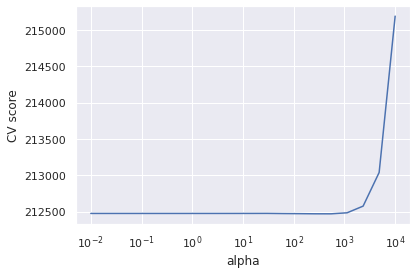

In [ ]:

alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [ ]:

lasso_pipeline2 = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Lasso(best_alpha))
])

model = lasso_pipeline2.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

RMSE = 223974.0364


In [ ]:
lasso_zeros = np.sum(lasso_pipeline2.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 1


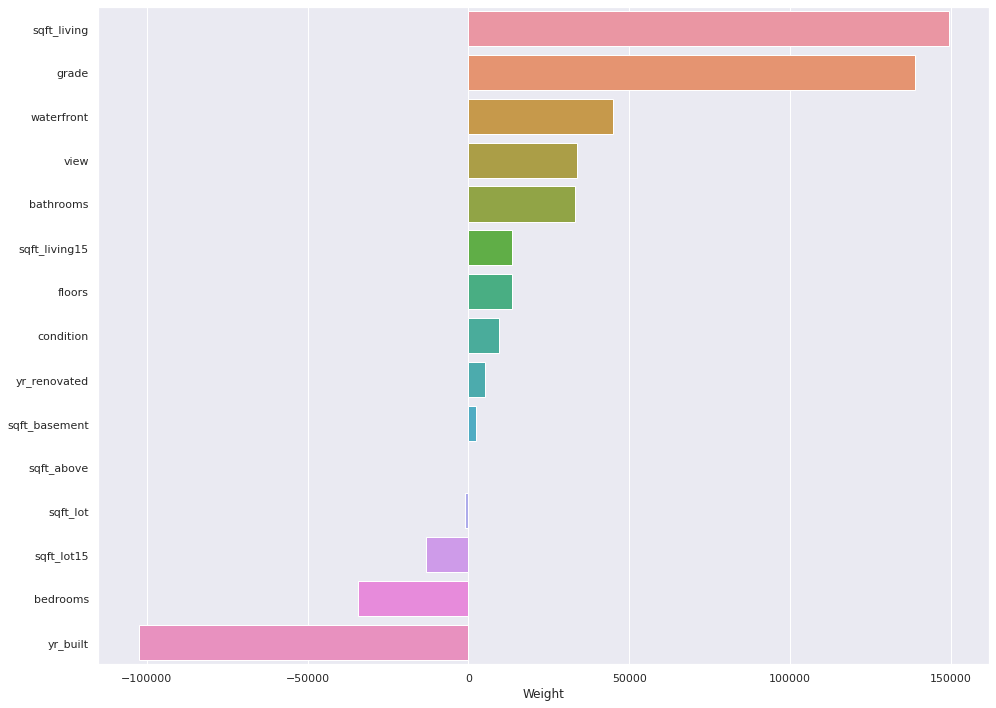

In [ ]:
def weights(features, weights):
    fig, axs = plt.subplots(figsize=(14, 10))
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs)
    axs.set_xlabel("Weight")
    plt.tight_layout()

    
weights(X.columns, lasso_pipeline2.steps[-1][-1].coef_ )

Таким образом, Lasso-регрессия служит методом отбора признаков.

У линейных моделей есть огромное преимущество: они имеют мало параметров, а поэтому их можно обучить даже на небольшой выборке. Если выборка большая, то параметры модели получится оценить более надёжно — но в то же время есть риск, что данные будут слишком разнообразными, чтобы линейная модель могла уловить все закономерности в них. Иногда можно улучшить ситуацию путём разбиения признакового пространства на несколько областей и построения своей модели в каждой из них.

Попробуем для примера в нашей задаче разделить выборку на две части по признаку Grade. Это один из самых сильных признаков, и, возможно, разбиение по нему даст нам две выборки с заведомо разными ценами на дома.

Для начала вспомним, какое качество получается у обычной гребневой регрессии.

In [ ]:
pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 223893.9846


Text(0, 0.5, 'price')

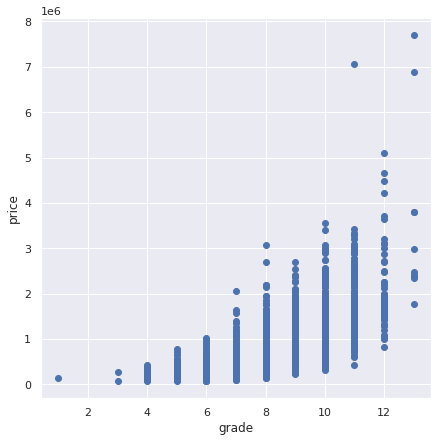

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train.grade, y_train)
plt.xlabel('grade')
plt.ylabel('price')

In [ ]:
threshold = 6
mask = (X_train.grade <= threshold)
X_train_1 = X_train[mask]
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask]
y_train_2 = y_train[~mask]

In [ ]:

pipeline1 = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

pipeline2 = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

model1 = pipeline1.fit(X_train_1, y_train_1)
model2 = pipeline2.fit(X_train_2, y_train_2)

y_pred_1 = model1.predict(X_test)
y_pred_2 = model2.predict(X_test)
mask_test = (X_test.grade <= threshold)
y_pred = y_pred_1.copy()
y_pred[~mask_test] = y_pred_2[~mask_test]

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 220888.1428


Получилось лучше!

In [ ]:
from sklearn.linear_model import ElasticNet
pipelineElasticNet = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', ElasticNet())
])

model = pipelineElasticNet.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 235715.6611


##Решим задачу классификации.

Двумя наиболее распространенными алгоритмами линейной классификации являются логистическая регрессия (logistic regression), реализованная в классе linear_model.LogisticRegression, и линейный метод опорных векторов (linear support vector machines) или линейный SVM, реализованный в классе svm.LinearSVC (SVC расшифровывается как support vector classifier – классификатор опорных векторов).

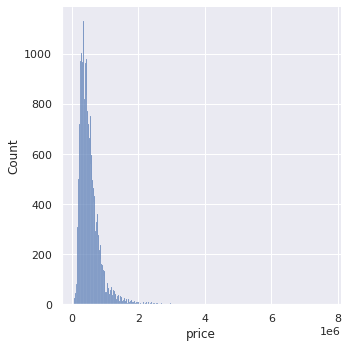

In [ ]:
sns.displot(y)

In [ ]:
threshold = 500000
y2 = y.copy()
mask = (y2 <= threshold)
y2[mask] = 1
y2[~mask] = 0

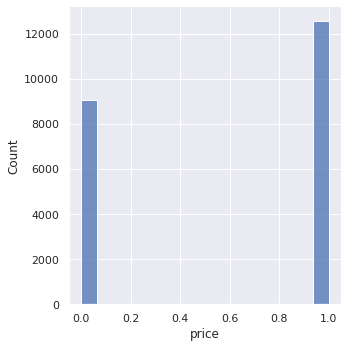

In [ ]:
sns.displot(y2)

По умолчанию обе модели используют L2 регуляризацию, тот же самый метод, который используется в гребневой регрессии.

Для LogisticRegression и LinearSVC компромиссный параметр, который определяет степень регуляризации, называется C, и более высокие значения C соответствуют меньшей регуляризации. Другими словами, когда вы используете высокое значение параметра C, LogisticRegression и LinearSVC пытаются подогнать модель к обучающим данным как можно лучше, тогда как при низких значениях параметра C модели делают больший акцент на поиске вектора коэффициентов (w), близкого к нулю.
Существует еще одна интересная деталь, связанная с работой параметра C. Использование низких значений C приводит к тому, что алгоритмы пытаются подстроиться под «большинство» точек данных, тогда как использование более высоких значений C подчеркивает важность того, чтобы каждая отдельная точка данных была классифицирована правильно.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state = 42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LinearSVC().fit(X_train_scaled, y2_train)
print("Правильность на обучающем наборе: {:.5f}".format(logreg.score(X_train_scaled, y2_train)))
print("Правильность на тестовом наборе: {:.5f}".format(logreg.score(X_test_scaled, y2_test)))

Правильность на обучающем наборе: 0.80957
Правильность на тестовом наборе: 0.81076


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Значение по умолчанию C=1 обеспечивает неплохое качество модели, правильность на обучающем и тестовом наборах составляет 81%.

In [ ]:
logreg = LogisticRegression().fit(X_train_scaled, y2_train)
print("Правильность на обучающем наборе: {:.5f}".format(logreg.score(X_train_scaled, y2_train)))
print("Правильность на тестовом наборе: {:.5f}".format(logreg.score(X_test_scaled, y2_test)))

Правильность на обучающем наборе: 0.81162
Правильность на тестовом наборе: 0.81046


In [ ]:
logreg = LogisticRegression(C=0.001).fit(X_train_scaled, y2_train)
print("Правильность на обучающем наборе: {:.5f}".format(logreg.score(X_train_scaled, y2_train)))
print("Правильность на тестовом наборе: {:.5f}".format(logreg.score(X_test_scaled, y2_test)))

Правильность на обучающем наборе: 0.79873
Правильность на тестовом наборе: 0.80429


In [ ]:
def roc_auc_plot(y_true, y_pred_proba):
    '''
    Функция считает AUC и отрисовывает ROC кривую:
        y_true - истинное значение класса
        y_pred_proba - предсказанная вероятность класса [:, 1]
    '''
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.title('ROC AUC = %0.3f' % roc_auc, fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15, loc = 'lower right')

In [ ]:
y_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

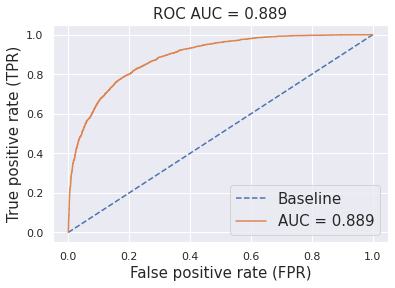

In [ ]:
roc_auc_plot(y2_test,y_pred_prob)